## DNA-seqFISH輝点の検出

ここでは、DNA-seqFISH輝点を決定する。
次に、以下の" "の間に、githubからダウンロードしたフォルダのパスを指定する。

In [1]:
import os

# 現在のディレクトリのパスを取得
current_directory = os.getcwd()

# 現在のディレクトリの2つ上の階層のパスを取得
dir = os.path.dirname(current_directory)
print(dir)

for Pos in range(1, 5):  # 1から4までの数値に対してループ。必要であれば変更が必要。
    # ImageJ マクロの 'IJ.pad(Pos, 2)' に相当する部分
    Pos_padded = str(Pos).zfill(2)

    # ディレクトリのパスを組み立てる
    directory_path = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination", "Pos" + Pos_padded, "candidate")

    # ディレクトリを作成する
    os.makedirs(directory_path, exist_ok=True)



import pandas as pd
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
# print("Big-FISH version: {0}".format(bigfish.__version__))


def spot_detect(Pos_no, file_name, threshold):                
    path_input = os.path.join(dir,"1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # smFISHの画像を選択する。
    dna  = stack.read_image(path)

    # 画像表示用のMIP画像を生成
    dna_mip = stack.maximum_projection(dna)

    # DNA-seqFISH MIP画像
    path = os.path.join(dir,"1_processed_images", "4_segmentation", 
                        Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # 細胞核segmentation画像
    path = os.path.join(dir,"1_processed_images", "4_segmentation", 
                        Pos_no, "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    # ここで、XY軸に触れている核は排除する
    # 画像辺縁部に細胞質が触れている細胞IDを抽出
    cells_cropped = np.unique(nuc_seg[0]).tolist()
    cells_cropped = cells_cropped + np.unique(nuc_seg[-1]).tolist()
    cells_cropped = cells_cropped + np.unique(nuc_seg[:,0]).tolist()
    cells_cropped = cells_cropped + np.unique(nuc_seg[:,-1]).tolist()
    cells_cropped = list(set(cells_cropped)) 
    cells_cropped.remove(0)
    # print("Cropped cells are : ", cells_cropped)

    for i in cells_cropped:
        nuc_seg = np.where(nuc_seg == i, 0, nuc_seg)

    # maskを作る。
    nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)
    dna_masked = dna * nuc_seg_mask
    dna_masked = dna_masked.astype('uint16')
    dna_masked_mip = stack.maximum_projection(dna_masked)

    # 細胞核画像
    path = os.path.join(dir,"1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)



    # Spot detection
    #以下はfiltering, local maximaの検出、最適な閾値の検出、閾値による輝点の検出を一度に実施する。

    spots = detection.detect_spots(
        images=dna_masked, 
        threshold = threshold,
        return_threshold=False, 
        voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx) これは固定。
        spot_radius=(240, 189, 189))  
    plot.plot_detection(dna_masked_mip, spots, contrast=True)
    
    
# 該当するND, Colのspot画像を取得して、napariで表示するためのfunction
def napari_check(ND,Col,Pos_no):
    file_name = 'ND'+str(ND)+'_C'+str(Col)+'_TyD.tif'

    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # smFISHの画像を選択する。
    dna  = stack.read_image(path)

    # 画像表示用のMIP画像を生成
    dna_mip = stack.maximum_projection(dna)

    
    # fiducial marker強調画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                    Pos_no, "Fiducial_enhance_stack.tif")
    fiducial  = stack.read_image(path)
    
    # DNA-seqFISH 488 MIP画像
    path = os.path.join(dir, "1_processed_images","4_segmentation", 
                        Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # 細胞核segmentation画像
    path = os.path.join(dir, "1_processed_images","4_segmentation", 
                        Pos_no, "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)

    dna_masked = dna * nuc_seg_mask
    dna_masked = dna_masked.astype('uint16')

    dna_masked_mip = stack.maximum_projection(dna_masked)

    # 細胞核画像
    path = os.path.join(dir, "1_processed_images","3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)



    import pandas as pd

    # ここで、各種情報が記載されたファイルを読み出す。
    ref_a = os.path.join(dir, "X1_accessory_data","DNA-RNA-seqFISH-probe-summary.csv")
    ref_data = pd.read_csv(ref_a, index_col=0)

    stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'

    ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]


    path = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination", 
                                    Pos_no, "candidate",ref_data_res['Locus_ID'][0]+"__spots.csv")
    df_concat_Nanog = pd.read_csv(path, index_col=0)

    spots_detected = df_concat_Nanog[['Z_pix', 'Y_pix', 'X_pix']].to_numpy()



    # napariでチェックし、適宜修正する。
    # ここで、fiducialと6番染色体が近いものは無理にアサインしないことにする。

    from skimage import data
    import napari

    viewer = napari.view_image(fiducial, name='fiducial',
                colormap = 'red', gamma = 0.52,
                          contrast_limits = [250, 2000])
    viewer.add_image(DNA_seqFISH, name='DNA_seqFISH',
                               opacity = 0.25, colormap = 'blue',
                               contrast_limits = [400, 3000], blending='additive')
    viewer.add_image(nuc, name='nuc', opacity = 0.15, blending='additive',
                              contrast_limits = [1000, 20000])
    viewer.add_labels(nuc_seg, opacity = 0.15,blending='additive')
    viewer.add_image(dna, colormap = 'green',
                     opacity = 0.2, blending='additive', gamma = 2.0,
                    contrast_limits = [200, 1600])

    viewer.add_points(spots_detected, size=15, 
                      edge_width=0.2, 
                      symbol = "ring",
                      edge_color = 'red', 
                      face_color = 'red', 
                      n_dimensional = True, blending='additive', name='spots_detected')
    
    return viewer


## Detect spots

まず最初に、すべてのseqFISH画像について、輝点検出の閾値を事前に決定しておく。
決めた閾値は以下に記載する。
/Users/HiroshiOchiai/Library/CloudStorage/OneDrive-広島大学/ドキュメント/Nanog-Long-range-interaction/論文/2024-seqFISH-MMB/231224-image_analysis_v1/DNA-RNA-seqFISH-probe-summary.csv

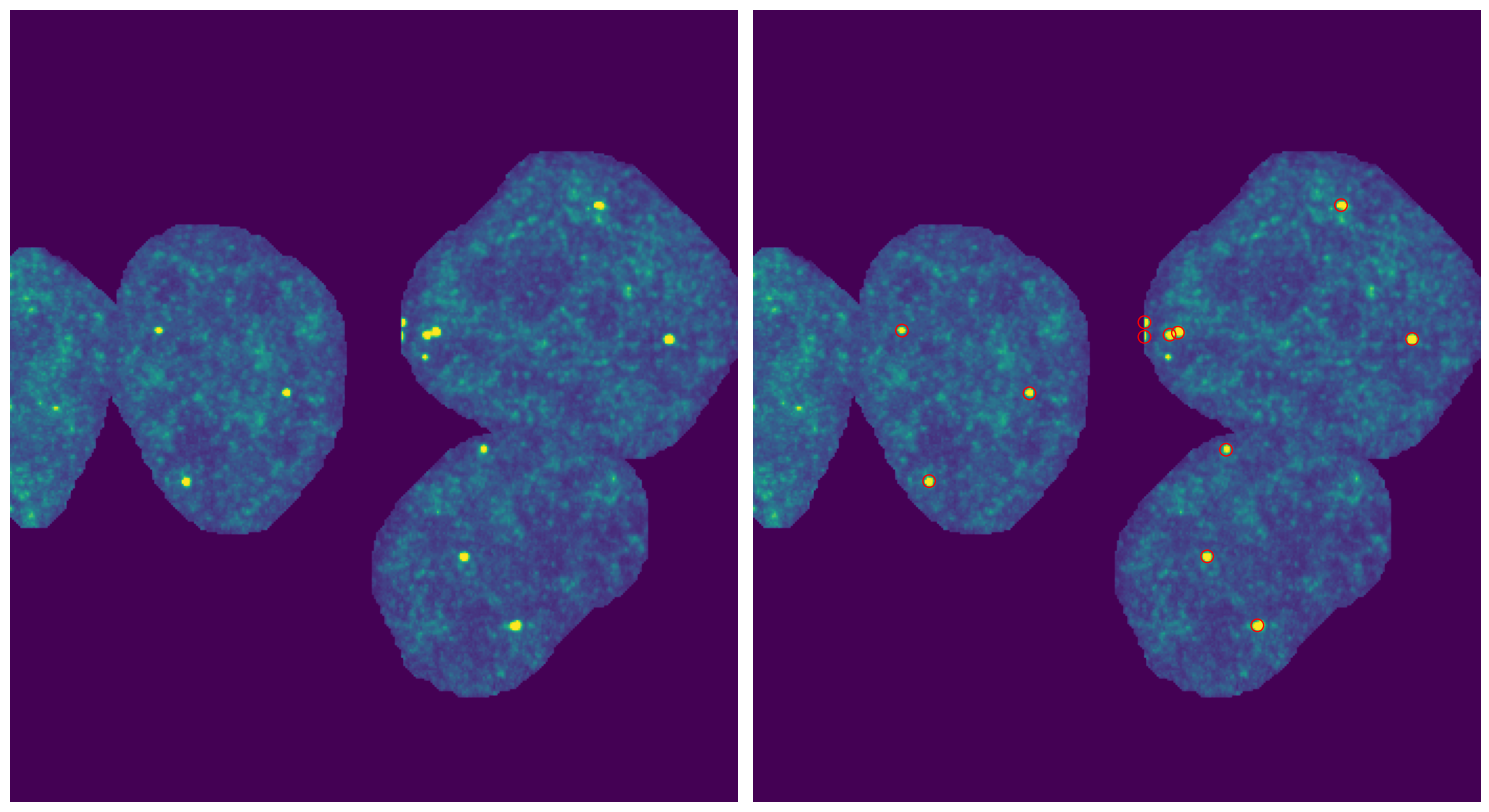

In [5]:
# ここで、解析対象となるPositionを決める。

Pos_no = "Pos01"

file_name = 'ND45_C3_TyD.tif'
threshold = 200

spot_detect(Pos_no, file_name, threshold)

In [6]:
# ここで、各種情報が記載されたファイルを読み出す。

dir_a = os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv")
ref_data = pd.read_csv(dir_a, index_col=0)


# Pos_no の範囲を指定
Pos_no_range = ['Pos01', 'Pos02', 'Pos03']


for Pos_no in Pos_no_range:
    # ND33~72がDNA-seqFISH。
    for ND in range(33,73):
        for Col in range(1,4):
            file_name = 'ND'+str(ND)+'_C'+str(Col)+'_TyD.tif'

            path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

            path = os.path.join(path_input, Pos_no, file_name)
            # smFISHの画像を選択する。
            dna  = stack.read_image(path)

            # 画像表示用のMIP画像を生成
            dna_mip = stack.maximum_projection(dna)

            # DNA-seqFISH MIP画像
            path = os.path.join(dir,"1_processed_images","4_segmentation", 
                                Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
            DNA_seqFISH  = stack.read_image(path)

            # 細胞核segmentation画像
            path = os.path.join(dir,"1_processed_images","4_segmentation", 
                                Pos_no, "02_nuc_seg_human_corrected.tif")
            nuc_seg  = stack.read_image(path)
            nuc_seg = nuc_seg.astype('uint16')

            # ここで、XY軸に触れている核は排除する
            # 画像辺縁部に細胞質が触れている細胞IDを抽出
            cells_cropped = np.unique(nuc_seg[:,0,:]).tolist()
            cells_cropped = cells_cropped + np.unique(nuc_seg[:,-1,:]).tolist()
            cells_cropped = cells_cropped + np.unique(nuc_seg[:,:,0]).tolist()
            cells_cropped = cells_cropped + np.unique(nuc_seg[:,:,-1]).tolist()
            cells_cropped = list(set(cells_cropped)) 
            cells_cropped.remove(0)
            # print("Cropped cells are : ", cells_cropped)


            for i in cells_cropped:
                nuc_seg = np.where(nuc_seg == i, 0, nuc_seg)


            # maskを作る。
            nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)


            dna_masked = dna * nuc_seg_mask
            dna_masked = dna_masked.astype('uint16')

            dna_masked_mip = stack.maximum_projection(dna_masked)

            # 細胞核画像
            path = os.path.join(dir,"1_processed_images","3_diveded_files", 
                                Pos_no, "ND53_C4_TyD.tif")
            nuc  = stack.read_image(path)
            nuc_mip = stack.maximum_projection(nuc)




            # Spot detection

            #以下はfiltering, local maximaの検出、最適な閾値の検出、閾値による輝点の検出を一度に実施する。

            # Thresholdは事前に設定した数値を採用する。

            stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'
            ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]
            threshold = ref_data_res['Threshold'][0].astype('int').item()

            spots = detection.detect_spots(
                images=dna_masked, 
                threshold = threshold,
                return_threshold=False, 
                voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx) これは固定。
                spot_radius=(240, 189, 189))  
            
            
            if spots.shape[0] > 0: 

                # subpixel fitting
                Spots_sub = bigfish.detection.fit_subpixel(dna, spots.astype('int64'),
                                                        voxel_size = (130, 130, 130),
                                                        spot_radius=(240, 189, 189))



                # ここで、輝点強度が各細胞内で上位10位までに絞る。


                import pandas as pd
                data_df_spots = pd.DataFrame(data=Spots_sub, 
                                    index=range(1,len(Spots_sub)+1),
                                    columns=["Z_pix", "Y_pix", "X_pix"])

                # 該当する細胞にアサインする
                # https://stackoverflow.com/questions/68341726/how-to-test-if-coordinates-are-inside-a-label-or-mask
                coords_int = np.round(Spots_sub).astype(int)  # or np.floor, depends

                # ここで、(68, 998, 969)の範囲外になるものが出てくることがあるようだ。
                coords_int_t = coords_int.T
                coords_int_t[0] = np.where(coords_int_t[0] > nuc.shape[0]-1, nuc.shape[0]-1, coords_int_t[0])
                coords_int_t[0] = np.where(coords_int_t[0] < 0, 0, coords_int_t[0])
                coords_int_t[1] = np.where(coords_int_t[1] > nuc.shape[1]-1, nuc.shape[1]-1, coords_int_t[1])
                coords_int_t[1] = np.where(coords_int_t[1] < 0, 0, coords_int_t[1])
                coords_int_t[2] = np.where(coords_int_t[2] > nuc.shape[2]-1, nuc.shape[2]-1, coords_int_t[2])
                coords_int_t[2] = np.where(coords_int_t[2] < 0, 0, coords_int_t[2])

                coords_int = coords_int_t.T

                values_at_coords = nuc_seg[tuple(coords_int.T)]

                #PandasデータにCell IDを入れ込む
                data_df_spots['Cell_ID'] = values_at_coords

                # #Cell IDが０のものを除去する。
                data_df_spots = data_df_spots[data_df_spots['Cell_ID'] != 0]
                data_df_spots2 = data_df_spots


                stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'

                ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]

                data_df_spots2['Pos_ID'] = Pos_no
                data_df_spots2['geneID'] = ref_data_res['geneID'][0]
                data_df_spots2['Locus_ID'] = ref_data_res['Locus_ID'][0]
                data_df_spots2['Stack_ID'] = stack_id
                data_df_spots2['Probe_position_Start_mm10'] = ref_data_res['Probe_position_Start_mm10'][0].astype('int')
                data_df_spots2['Probe_position_End_mm10'] = ref_data_res['Probe_position_End_mm10'][0].astype('int')


                # ファイルを書き出す。
                import pandas as pd
                path_output = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination")
                file_name = ref_data_res['Locus_ID'][0] + '__spots.csv'
                path = os.path.join(path_output, Pos_no, 'candidate', file_name)
                data_df_spots2.to_csv(path)
            
            else : 
                data_df_spots2 = pd.DataFrame(index=[], columns=['Z_pix', 'Y_pix', 'X_pix', 'Cell_ID', 'Pos_ID', 
                                            'geneID', 'Locus_ID', 'Stack_ID', 'Probe_position_Start_mm10', 
                                            'Probe_position_End_mm10'])
                path_output = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination")
                file_name = ref_data_res['Locus_ID'][0] + '__spots.csv'
                path = os.path.join(path_output, Pos_no, 'candidate', file_name)
                data_df_spots2.to_csv(path)

以下で確認する。

In [10]:
# 該当するNDとColを指定して、実行すれば、napariが開く。
# napariの中で、spots_detectedの輝点を修正し、目的の輝点のみにする。一つのアレル周辺に複数輝点が認められる場合はそのままでいい。
# fiducial markerもできるだけ排除する。

ND = 50
Col = 1
Pos_no = 'Pos01'

viewer = napari_check(ND,Col,Pos_no)

ここで、データをまとめ、fiducial markerをアサインする。
1.5ピクセル距離で、うまく輝点検出できていない場合も含めて、95% 箇所以上 (114箇所)で輝点が検出できるものは、fiducial markerとみなす。
このとき、同じタイミングで撮影されたfiducial marker同士をまとめ、fiducial markerの変化量を調べる。
全輝点に対して、最も近傍にあるfiducial markerで補正する。
最終的にfiducial markerのデータを排除する。

In [15]:
# 空データを用意する。
import pandas as pd

summary_data = pd.DataFrame()

for i in range(1,4):
    # print(i, ' / 50..')
    Pos_no = 'Pos' + str(i).zfill(2)

    # ND33~72がDNA-seqFISH。
    for ND in range(33,73):
        for Col in range(1,4):
            

            # ここで、各種情報が記載されたファイルを読み出す。
            dir_a = os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv")
            ref_data = pd.read_csv(dir_a, index_col=0)

            stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'

            ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]

            path_input = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination")
            file_name = ref_data_res['Locus_ID'][0] + '__spots.csv'
            path = os.path.join(path_input, Pos_no, 'candidate', file_name)
            df_1 = pd.read_csv(path)
            df_1['Channel'] = Col
            df_1['ND_id'] = ND
            df_1['fov'] = i

            summary_data = pd.concat([summary_data, df_1])

summary_data = summary_data.drop('Unnamed: 0', axis = 1)
summary_data = summary_data.reset_index(drop=True)
summary_data

,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov
0,44.417862,302.386467,232.269030,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1
1,45.633934,209.047680,225.978353,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1
2,60.422757,152.288898,71.187153,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1
3,60.866119,215.936677,82.399050,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1
4,38.848028,291.947554,222.274554,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3
2546,44.297399,271.846628,112.173021,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3
2547,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3
2548,46.157444,194.284831,182.980421,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3


候補fiducial markerを決定する。 

In [16]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
print("Big-FISH version: {0}".format(bigfish.__version__))
import scipy.spatial as ss  
from scipy.spatial import distance

summary_data['fiducial'] = 0

_df = pd.DataFrame()

for Pos in range(1,4):
    # print(Pos, ' / 50..')
    
    Pos_no = 'Pos' + str(Pos).zfill(2)
    
    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    # fiducial marker強調画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        Pos_no, "Fiducial_enhance_stack.tif")
    fiducial  = stack.read_image(path)

    # DNA-seqFISH MIP画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # 細胞核segmentation画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        Pos_no, "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)


    fiducial_masked = fiducial * nuc_seg_mask
    fiducial_masked = fiducial_masked.astype('uint16')



    # 細胞核画像
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)
    
    
    
    spots_fid = detection.detect_spots(
                        threshold = 150,
                        return_threshold = False,
                        images=fiducial_masked, 
                        voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx) これは固定。
                        spot_radius=(240, 189, 189))  
    #fiducial marker輝点を選抜する。 https://stackoverflow.com/questions/10818546/finding-index-of-nearest-point-in-numpy-arrays-of-x-and-y-coordinates
    
    
    
    # napariでチェックし、適宜修正する。
    # ここで、fiducialと6番染色体が近いものは無理にアサインしないことにする。

#     from skimage import data
#     import napari

#     viewer = napari.view_image(fiducial, name='fiducial',
#                     colormap = 'red', gamma = 0.52,
#                               contrast_limits = [250, 2000])
#     viewer.add_image(DNA_seqFISH, name='DNA_seqFISH',
#                     opacity = 0.25, colormap = 'blue',
#                               contrast_limits = [400, 3000], blending='additive')
#     viewer.add_image(nuc, name='nuc', opacity = 0.15, blending='additive',
#                               contrast_limits = [1000, 20000])
#     viewer.add_labels(nuc_seg, opacity = 0.15,blending='additive')

#     viewer.add_points(spots_fid, size=15, 
#                       edge_width=0.2, 
#                       symbol = "ring",
#                       edge_color = 'blue', 
#                       face_color = 'blue', 
#                       n_dimensional = True, blending='additive', name='fiducial_spots')
#     napariで調整したデータを取得する。
#         spots_fid = viewer.layers['fiducial_spots'].data.astype('uint16')
    
    # https://www.delftstack.com/ja/howto/numpy/calculate-euclidean-distance/

    threshold_dist = 3.0 #距離が3ピクセル以内にあるものをすべてfiducialとみなす。
    
    c = summary_data.loc[summary_data['fov']==Pos]
    c = c.reset_index(drop=True)

    # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
    # kd tree の作成 (leafsizeは展開をしない節内点数上限)

    tree = ss.KDTree(spots_fid)

    for i in range(len(c)):
        d, index = tree.query(c.loc[i,['Z_pix','Y_pix','X_pix']].tolist())
        if d<threshold_dist:
            c.loc[i,['fiducial']] = 1
    _df = pd.concat([_df,c], axis=0)
    

_df

Big-FISH version: 0.6.2


,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial
0,44.417862,302.386467,232.269030,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0
1,45.633934,209.047680,225.978353,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1
2,60.422757,152.288898,71.187153,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1
3,60.866119,215.936677,82.399050,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0
4,38.848028,291.947554,222.274554,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0
903,44.297399,271.846628,112.173021,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,1
904,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0
905,46.157444,194.284831,182.980421,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0


In [17]:
print(len(_df))
print('fiducial spots : ',sum(_df['fiducial']==1))
print('non-fiducial spots : ',sum(_df['fiducial']==0))

summary_data = _df.copy()

2550
fiducial spots :  750
non-fiducial spots :  1800


In [18]:
# summary_data = summary_data.drop(['index'], axis=1)

summary_data = summary_data.reset_index(drop=True)
summary_data['spot_ID'] = summary_data.index

summary_data

,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial,spot_ID
0,44.417862,302.386467,232.269030,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0,0
1,45.633934,209.047680,225.978353,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,1
2,60.422757,152.288898,71.187153,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,2
3,60.866119,215.936677,82.399050,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0,3
4,38.848028,291.947554,222.274554,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2545
2546,44.297399,271.846628,112.173021,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,1,2546
2547,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2547
2548,46.157444,194.284831,182.980421,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2548


In [19]:
summary_data.ND_id.unique()

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72])

次に、異なる色で近傍(2ピクセル以下)にあるfiducial同士は同一のfiducialに属すると思われるので、それらを結びつける。
ただし、同じ色で近傍にfiducialと思われる輝点がある場合、補正が難しくなる可能性がある。そのため、同一の色で3ピクセル以内にあるfiducial同士は補正には使用しないことにする。

In [20]:
a = summary_data.copy()
a['fiducial_to_be_excluded'] = 0

a_1 = a.loc[a['fiducial']==1,:]
a_0 = a.loc[a['fiducial']==0,:]

threshold_dist = 3.0

h = pd.DataFrame()

for Pos in range(1,4):
    # print(Pos, ' / 50..')
    for ND in list(set(summary_data['ND_id'].values)):
        b = a_1.loc[(a['fov']==Pos)&(a['ND_id']==ND),:]
        for Channel in range(1,4):
            c = b.loc[b['Channel']==Channel,:]
            c = c.reset_index(drop=True)
            # 最近傍の輝点を見つける。https://inarizuuuushi.hatenablog.com/entry/2019/02/21/100000
            # kd tree の作成 (leafsizeは展開をしない節内点数上限)
            spots_fid = c.loc[:,['Z_pix','Y_pix','X_pix']].values
            tree = ss.KDTree(spots_fid)

            for i in range(len(c)):
                d, index = tree.query(c.loc[i,['Z_pix','Y_pix','X_pix']].tolist(),k=[2]) # second nearest
                if d<threshold_dist:
                    c.loc[i,['fiducial_to_be_excluded']] = 1
            h = pd.concat([h,c], axis=0)

h = pd.concat([h,a_0], axis=0)
        
summary_data_fid = pd.DataFrame()

for Pos in range(1,4):
    # print(Pos, ' / 50..')

    _df = h.loc[h['fov']==Pos,:].copy()
    
    _df.loc[:,'fiducial_for_correct_id'] = ''

    from scipy.spatial import distance

    for ND in range(33,73):
        df_1 = _df[_df['ND_id'] == ND]
        df_2 = df_1[(df_1['fiducial'] == 1)&(df_1['fiducial_to_be_excluded'] == 0)]

        df_2_ch1 = df_2[df_2['Channel'] == 1]
        df_2_ch2 = df_2[df_2['Channel'] == 2]
        df_2_ch3 = df_2[df_2['Channel'] == 3]

        df_2_ch1 = df_2_ch1.reset_index(drop=True)

        for ch1 in range(len(df_2_ch1)):
            a = df_2_ch1.loc[ch1,['Z_pix','Y_pix','X_pix']].astype('uint64')
            b = df_2_ch2.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
            c = distance.cdist(np.append([a.values],[a.values], axis=0), b.values, 'euclidean')    
            if c.shape[1] > 0:
                if np.amin(c) < 2:
                    e = df_2_ch3.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
                    f = distance.cdist(np.append([a.values],[a.values], axis=0), e.values, 'euclidean')
                    if f.shape[1] > 0:
                        if np.amin(f) < 2:
                            a_name = 'spotID_'+str(df_2_ch1.iloc[ch1,df_2_ch1.columns.get_loc('spot_ID')])+'_'+str(df_2_ch2.iloc[np.argmin(c, axis=1)[0],df_2_ch2.columns.get_loc('spot_ID')])+'_'+str(df_2_ch3.iloc[np.argmin(f, axis=1)[0],df_2_ch3.columns.get_loc('spot_ID')])
                            
                            _df.loc[_df['spot_ID'] == df_2_ch1.iloc[ch1,df_2_ch1.columns.get_loc('spot_ID')], 'fiducial_for_correct_id'] = a_name
                            _df.loc[_df['spot_ID'] == df_2_ch2.iloc[np.argmin(c, axis=1)[0],df_2_ch2.columns.get_loc('spot_ID')], 'fiducial_for_correct_id'] = a_name
                            _df.loc[_df['spot_ID'] == df_2_ch3.iloc[np.argmin(f, axis=1)[0],df_2_ch3.columns.get_loc('spot_ID')], 'fiducial_for_correct_id'] = a_name
    summary_data_fid = pd.concat([summary_data_fid,_df], axis=0)
        
summary_data_fid

,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id
0,45.633934,209.047680,225.978353,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,1,0,spotID_1_6_11
1,60.422757,152.288898,71.187153,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,2,0,
0,45.143595,209.196794,225.859465,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,1,6,0,spotID_1_6_11
1,59.535616,152.448166,70.850295,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,1,9,0,
0,44.202081,209.415058,225.881952,7,Pos01,Nanog_assoc#1,Loc_001,ND33_C3_TyD,94683691,94696365,3,33,1,1,11,0,spotID_1_6_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2540,45.476274,193.477352,177.708528,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,0,2540,0,
2542,53.232433,244.119919,104.286331,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,0,2542,0,
2545,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2545,0,
2547,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2547,0,


In [21]:
print('fiducial_for_correct_id assigned : ',sum(summary_data_fid['fiducial_for_correct_id']!=''))
print('fiducial_for_correct_id not assigned : ',sum(summary_data_fid['fiducial_for_correct_id']==''))

fiducial_for_correct_id assigned :  495
fiducial_for_correct_id not assigned :  2055


In [22]:
summary_data_fid.ND_id.unique()

array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72])

非fiducial輝点と最も近傍に有るfiducial markerを結びつける。


In [23]:
summary_data_fid2 = pd.DataFrame()

for Pos in range(1,4):
    # print(Pos, ' / 50..')

    _df = summary_data_fid.loc[summary_data_fid['fov']==Pos,:].copy()
    _df['closeset_fid'] = ''

    from scipy.spatial import distance

    for ND in range(33,73):
        for col in range(1,4):
            df_1 = _df[(_df['fiducial_for_correct_id']=="")&
                        (_df['ND_id']==ND)&
                        (_df['Channel']==col)].copy()
            df_1['closeset_fid'] = ''
            df_2 = _df[(_df['fiducial_for_correct_id']!="")&
                        (_df['ND_id']==ND)&
                        (_df['Channel']==col)].copy()
            df_2['closeset_fid'] = ''
            a = df_1.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
            b = df_2.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
            c = distance.cdist(a, b, 'euclidean')
            if c.shape[1] > 0:
                # 以下で、aの中で、bのindexのものと最も近いことがわかる。
                d = np.argmin(c, axis=1)
                for i in range(len(df_1)):
                    df_1 = df_1.reset_index(drop=True)
                    df_2 = df_2.reset_index(drop=True)
                    df_1.loc[i,'closeset_fid'] = df_2.loc[d[i],'fiducial_for_correct_id']
                summary_data_fid2 = pd.concat([summary_data_fid2, df_1])

In [24]:
summary_data_fid2

,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id,closeset_fid
0,60.422757,152.288898,71.187153,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,2,0,,spotID_1_6_11
1,44.417862,302.386467,232.269030,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0,0,0,,spotID_1_6_11
2,60.866119,215.936677,82.399050,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0,3,0,,spotID_1_6_11
0,59.535616,152.448166,70.850295,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,1,9,0,,spotID_1_6_11
1,38.848028,291.947554,222.274554,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,0,4,0,,spotID_1_6_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,45.476274,193.477352,177.708528,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,0,2540,0,,spotID_2536_2544_2549
5,53.232433,244.119919,104.286331,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,0,2542,0,,spotID_2532_2541_2546
0,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2545,0,,spotID_2532_2541_2546
1,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2547,0,,spotID_2536_2544_2549


In [25]:
summary_data_fid2.ND_id.unique()

array([33, 34, 36, 38, 41, 43, 50, 51, 52, 53, 54, 61, 64, 65, 67, 68, 70,
       35, 37, 39, 40, 42, 44, 45, 46, 47, 48, 49, 55, 56, 57, 58, 59, 60,
       62, 63, 66, 69, 71, 72])

fiducialの色間のずれを計算する。

summary_data_fid : これは全データ、fiducialと思われるものには、色間で関連付けたIDが割り振られている
summary_data_fid2 : fiducialではないと判定されたものうち、最近傍のfiducialがアサインされたもの

In [26]:
summary_data_fid3 = pd.DataFrame()

_df0 = summary_data_fid.loc[summary_data_fid['fiducial_for_correct_id']!='',:].copy()

for Pos in range(1,4):
    # print(Pos, ' / 50..')
    
    _df = _df0.loc[_df0['fov']==Pos,:].copy()
    
    unique_fid_list = _df["fiducial_for_correct_id"].unique()

    from scipy.spatial import distance

    for fid in range(1,len(unique_fid_list)): # 最初は "" だけなので、飛ばす。
        df_2 = _df.loc[_df['fiducial_for_correct_id']==unique_fid_list[fid],:].copy()
        df_2['cor_Z_pix'] = 0.0
        df_2['cor_Y_pix'] = 0.0
        df_2['cor_X_pix'] = 0.0
        df_2 = df_2.reset_index(drop=True)

        a = df_2.loc[df_2['Channel']==1,['Z_pix','Y_pix','X_pix']].astype('float64')
        b = df_2.loc[df_2['Channel']==2,['Z_pix','Y_pix','X_pix']].astype('float64')
        c = pd.concat([a,b])
        c_dif = c.diff()
        # if len(df_2.loc[df_2['Channel']==2,'cor_Z_pix']) > 0: #'spotID_119951_119992_120045'はfiducialのものしか認識されていないため、これを入れないとエラーが出る。
        df_2.loc[df_2['Channel']==2,'cor_Z_pix'] = c_dif.loc[1,'Z_pix':'X_pix'][0]
        df_2.loc[df_2['Channel']==2,'cor_Y_pix'] = c_dif.loc[1,'Z_pix':'X_pix'][1]
        df_2.loc[df_2['Channel']==2,'cor_X_pix'] = c_dif.loc[1,'Z_pix':'X_pix'][2]

        d = df_2.loc[df_2['Channel']==3,['Z_pix','Y_pix','X_pix']].astype('float64')
        # if len(d) > 0: #'spotID_262540_262569_262618'はfiducialのものしか認識されていないため、これを入れないとエラーが出る。
        e = pd.concat([a,d])
        e = e.reset_index()
        e_dif = e.diff()
        df_2.loc[df_2['Channel']==3,'cor_Z_pix'] = e_dif.loc[1,'Z_pix':'X_pix'][0]
        df_2.loc[df_2['Channel']==3,'cor_Y_pix'] = e_dif.loc[1,'Z_pix':'X_pix'][1]
        df_2.loc[df_2['Channel']==3,'cor_X_pix'] = e_dif.loc[1,'Z_pix':'X_pix'][2]   

        summary_data_fid3 = pd.concat([summary_data_fid3, df_2])
    
summary_data_fid3 # fiducial markerの一覧で、かつ補正値が含まれる。


,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id,cor_Z_pix,cor_Y_pix,cor_X_pix
0,45.833399,208.983304,226.046122,7,Pos01,Ppp4r2,Loc_007,ND34_C1_TyD,100840627,100864437,1,34,1,1,14,0,spotID_14_19_25,0.000000,0.000000,0.000000
1,45.400678,209.239659,225.958594,7,Pos01,Foxp1,Loc_005,ND34_C2_TyD,99036509,99052484,2,34,1,1,19,0,spotID_14_19_25,-0.432721,0.256355,-0.087528
2,44.991089,209.608022,225.774672,7,Pos01,Nanog_assoc#2,Loc_003,ND34_C3_TyD,97195873,97214372,3,34,1,1,25,0,spotID_14_19_25,-0.842310,0.624718,-0.271450
0,60.884691,152.622504,70.864114,6,Pos01,Ppp4r2,Loc_007,ND34_C1_TyD,100840627,100864437,1,34,1,1,18,0,spotID_18_22_29,0.000000,0.000000,0.000000
1,60.331359,152.916182,70.630697,6,Pos01,Foxp1,Loc_005,ND34_C2_TyD,99036509,99052484,2,34,1,1,22,0,spotID_18_22_29,-0.553332,0.293679,-0.233416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,44.976401,272.073607,112.800406,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,1,2541,0,spotID_2532_2541_2546,0.182372,-0.450587,-0.342082
2,44.297399,271.846628,112.173021,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,1,2546,0,spotID_2532_2541_2546,-0.496630,-0.677566,-0.969468
0,58.746369,173.410409,252.762833,4,Pos03,Resf1,Loc_120,ND72_C1_TyD,149297315,149321834,1,72,3,1,2536,0,spotID_2536_2544_2549,0.000000,0.000000,0.000000
1,58.798808,172.943062,252.576247,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,1,2544,0,spotID_2536_2544_2549,0.052439,-0.467347,-0.186585


In [27]:
summary_data_fid3.ND_id.unique()

array([34, 36, 38, 41, 43, 50, 51, 52, 53, 54, 61, 64, 65, 67, 68, 70, 35,
       37, 39, 40, 42, 44, 45, 46, 47, 48, 49, 55, 56, 57, 58, 59, 60, 62,
       63, 66, 69, 71, 72, 33])

fiducial markerで補正する。ここで、fiducialに近く、fiducialの可能性があるもの(fiducial = 1)を排除する。。

In [29]:
import datetime

summary_data_fid4 = summary_data_fid2
summary_data_fid4['cor_Z_pix'] = 0.0
summary_data_fid4['cor_Y_pix'] = 0.0
summary_data_fid4['cor_X_pix'] = 0.0
summary_data_fid4 = summary_data_fid4[summary_data_fid4['fiducial']==0].copy()

summary_data_fid4 = summary_data_fid4.reset_index(drop=True)


    
closeset_fid_list = summary_data_fid4["closeset_fid"].unique()

for i in range(len(closeset_fid_list)):
    if i % 1000 == 0:
        print('No:', i, "/ ",len(closeset_fid_list), '  time: ', datetime.datetime.now())
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                                 (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values) > 0 :
        summary_data_fid4.loc[(summary_data_fid4['Channel']==2)&
                (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Z_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values[0]

    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                                 (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values) > 0 :
        summary_data_fid4.loc[(summary_data_fid4['Channel']==2)&
                (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Y_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values[0]
        
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                                 (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values) > 0 :       
        summary_data_fid4.loc[(summary_data_fid4['Channel']==2)&
                (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_X_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values[0]


    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values) > 0 :            
        summary_data_fid4.loc[(summary_data_fid4['Channel']==3)&
                             (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Z_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                             (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values[0]
        
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values) > 0 :    
        summary_data_fid4.loc[(summary_data_fid4['Channel']==3)&
                         (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Y_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values[0]
        
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values) > 0 :    
        summary_data_fid4.loc[(summary_data_fid4['Channel']==3)&
                         (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_X_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values[0]
summary_data_fid4

No: 0 /  144   time:  2023-12-26 12:17:41.404746


,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,...,ND_id,fov,fiducial,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id,closeset_fid,cor_Z_pix,cor_Y_pix,cor_X_pix
0,44.417862,302.386467,232.269030,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,...,33,1,0,0,0,,spotID_1_6_11,0.000000,0.000000,0.000000
1,60.866119,215.936677,82.399050,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,...,33,1,0,3,0,,spotID_1_6_11,0.000000,0.000000,0.000000
2,38.848028,291.947554,222.274554,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,33,1,0,4,0,,spotID_1_6_11,0.000000,0.000000,0.000000
3,40.962773,325.148798,228.894764,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,33,1,0,5,0,,spotID_1_6_11,0.000000,0.000000,0.000000
4,56.083681,253.161321,207.646921,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,33,1,0,7,0,,spotID_1_6_11,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,45.476274,193.477352,177.708528,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,...,72,3,0,2540,0,,spotID_2536_2544_2549,0.052439,-0.467347,-0.186585
1507,53.232433,244.119919,104.286331,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,...,72,3,0,2542,0,,spotID_2532_2541_2546,0.182372,-0.450587,-0.342082
1508,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,...,72,3,0,2545,0,,spotID_2532_2541_2546,-0.496630,-0.677566,-0.969468
1509,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,...,72,3,0,2547,0,,spotID_2536_2544_2549,-0.043935,-0.716287,-0.417172


In [30]:
summary_data_fid4.ND_id.unique()

array([33, 34, 36, 38, 41, 43, 50, 51, 52, 53, 54, 61, 64, 65, 67, 68, 70,
       35, 37, 39, 40, 42, 44, 45, 46, 47, 48, 49, 55, 56, 57, 58, 59, 60,
       62, 63, 66, 69, 71, 72])

最終的な座標は、cor_Z_pix, cor_Y_pix, cor_X_pix分を、Z_pix, Y_pix, X_pixから引けばよい。

In [31]:
summary_data_fid5 = summary_data_fid4

summary_data_fid5['z'] = (summary_data_fid5['Z_pix'] - summary_data_fid5['cor_Z_pix'])
summary_data_fid5['y'] = (summary_data_fid5['Y_pix'] - summary_data_fid5['cor_Y_pix'])
summary_data_fid5['x'] = (summary_data_fid5['X_pix'] - summary_data_fid5['cor_X_pix'])

summary_data_fid5

,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,...,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id,closeset_fid,cor_Z_pix,cor_Y_pix,cor_X_pix,z,y,x
0,44.417862,302.386467,232.269030,7,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,...,0,0,,spotID_1_6_11,0.000000,0.000000,0.000000,44.417862,302.386467,232.269030
1,60.866119,215.936677,82.399050,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,...,3,0,,spotID_1_6_11,0.000000,0.000000,0.000000,60.866119,215.936677,82.399050
2,38.848028,291.947554,222.274554,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,4,0,,spotID_1_6_11,0.000000,0.000000,0.000000,38.848028,291.947554,222.274554
3,40.962773,325.148798,228.894764,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,5,0,,spotID_1_6_11,0.000000,0.000000,0.000000,40.962773,325.148798,228.894764
4,56.083681,253.161321,207.646921,7,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,7,0,,spotID_1_6_11,0.000000,0.000000,0.000000,56.083681,253.161321,207.646921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,45.476274,193.477352,177.708528,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,...,2540,0,,spotID_2536_2544_2549,0.052439,-0.467347,-0.186585,45.423835,193.944699,177.895113
1507,53.232433,244.119919,104.286331,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,...,2542,0,,spotID_2532_2541_2546,0.182372,-0.450587,-0.342082,53.050061,244.570507,104.628413
1508,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,...,2545,0,,spotID_2532_2541_2546,-0.496630,-0.677566,-0.969468,41.856401,227.231764,144.478759
1509,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,...,2547,0,,spotID_2536_2544_2549,-0.043935,-0.716287,-0.417172,45.486747,146.804404,166.437587


In [32]:
summary_data_fid5.ND_id.unique()

array([33, 34, 36, 38, 41, 43, 50, 51, 52, 53, 54, 61, 64, 65, 67, 68, 70,
       35, 37, 39, 40, 42, 44, 45, 46, 47, 48, 49, 55, 56, 57, 58, 59, 60,
       62, 63, 66, 69, 71, 72])

ここで、jieでの解析に必要なファイルタイプに整形する。

fov	cellID	channel	geneID	x	y	z

がカラムに必要。

In [33]:
summary_data_fid6 = pd.DataFrame(data={'fov': summary_data_fid5['fov'], 
                                      'cellID': summary_data_fid5['Cell_ID'],
                                      'channel': summary_data_fid5['Channel'],
                                      'geneID': summary_data_fid5['geneID'],
                                      'x': summary_data_fid5['x'],
                                      'y': summary_data_fid5['y'],
                                      'z': summary_data_fid5['z']}
)


summary_data_fid6

,fov,cellID,channel,geneID,x,y,z
0,1,7,1,Nanog_assoc#3,232.269030,302.386467,44.417862
1,1,6,1,Nanog_assoc#3,82.399050,215.936677,60.866119
2,1,7,2,Non_Nanog_assoc#1,222.274554,291.947554,38.848028
3,1,7,2,Non_Nanog_assoc#1,228.894764,325.148798,40.962773
4,1,7,2,Non_Nanog_assoc#1,207.646921,253.161321,56.083681
...,...,...,...,...,...,...,...
1506,3,4,2,Caprin2,177.895113,193.944699,45.423835
1507,3,1,2,Caprin2,104.628413,244.570507,53.050061
1508,3,1,3,Nanog_assoc#20,144.478759,227.231764,41.856401
1509,3,4,3,Nanog_assoc#20,166.437587,146.804404,45.486747


以下で、人力でfiducial markerと思われるものを除去する。


In [34]:
summary_data_fid7 = summary_data_fid6.copy()

In [35]:
# 該当するND, Colのspot画像を取得して、napariで表示するためのfunction


def napari_check2(fov):
    
    # fiducial marker強調画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                    'Pos'+str(fov).zfill(2), "Fiducial_enhance_stack.tif")
    fiducial  = stack.read_image(path)
    
    # DNA-seqFISH MIP画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        'Pos'+str(fov).zfill(2), "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # 細胞核segmentation画像
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        'Pos'+str(fov).zfill(2), "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    # 細胞核画像
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        'Pos'+str(fov).zfill(2), "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)


    # ここで、特定のfovの座標を取り出す。
    spots_detected = summary_data_fid6.loc[summary_data_fid6['fov']==fov,['z','y','x']].to_numpy()


    # napariでチェックし、適宜修正する。
    # ここで、fiducialと6番染色体が近いものは無理にアサインしないことにする。

    from skimage import data
    import napari

    viewer = napari.view_image(fiducial, name='fiducial',
                colormap = 'red', gamma = 0.52,
                          contrast_limits = [250, 2000])
    viewer.add_image(DNA_seqFISH, name='DNA_seqFISH',
                               opacity = 0.25, colormap = 'blue',
                               contrast_limits = [400, 3000], blending='additive')
    viewer.add_image(nuc, name='nuc', opacity = 0.15, blending='additive',
                              contrast_limits = [1000, 20000])
    viewer.add_labels(nuc_seg, opacity = 0.15,blending='additive')

    viewer.add_points(spots_detected, size=15, 
                      edge_width=0.2, 
                      symbol = "ring",
                      edge_color = 'red', 
                      face_color = 'red', 
                      n_dimensional = True, blending='additive', name='spots_detected', 
                      opacity = 0.15)
    
    return viewer


def get_spot_from_napari(fov, df):
    spots_corr = viewer.layers['spots_detected'].data
    b = df.loc[df['fov']!=fov,:].copy()
    
    a_0 = pd.DataFrame()
    
    for i in range(len(spots_corr)):
        a = df.loc[(df['fov']==fov)&(df['z']==spots_corr[i][0])&
                  (df['y']==spots_corr[i][1])&
                  (df['x']==spots_corr[i][2]),
                             :].copy()
        a_0 = pd.concat([a_0,a])
        
    c = pd.concat([a_0,b])
    return c

In [38]:
fov = 3
viewer = napari_check2(fov)

In [39]:
# fov = 2
summary_data_fid7 = get_spot_from_napari(fov, summary_data_fid7)
summary_data_fid7

,fov,cellID,channel,geneID,x,y,z
961,3,4,1,Nanog_assoc#3,176.830973,158.917121,41.103526
963,3,1,1,Nanog_assoc#3,88.087081,245.093353,51.938839
964,3,1,1,Nanog_assoc#3,111.204635,217.122576,57.091478
965,3,4,2,Non_Nanog_assoc#1,180.233448,157.845130,42.659038
967,3,1,2,Non_Nanog_assoc#1,85.486319,251.042791,52.428883
...,...,...,...,...,...,...,...
956,2,7,3,Nanog_assoc#20,117.417190,174.187770,64.847520
957,2,7,3,Nanog_assoc#20,144.442528,232.000373,73.126898
958,2,11,3,Nanog_assoc#20,145.333881,319.987953,73.187094
959,2,9,3,Nanog_assoc#20,267.044970,58.707753,76.844286


In [40]:
len(summary_data_fid7[summary_data_fid7['fov']==fov])

455

次に、各輝点の輝度値を細胞核内の輝度値の中央値で標準化し、その分布から、異様に数値が低いものを排除する。

In [58]:
dir_a = os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv")
ref_data = pd.read_csv(dir_a)

geneID_list = list(set(summary_data_fid7.geneID.values))

summary_data_fid8_int = pd.DataFrame()

from multiprocessing import Pool

import importlib
import intensity_calcs_v2
importlib.reload(intensity_calcs_v2)
from functools import partial

if __name__ == "__main__":
    with Pool(8) as p:
        fov = list(range(1,4))
        geneID_list_a = [geneID_list,] * len(range(1,3))
        summary_data_fid7_a = [summary_data_fid7,] * len(range(1,3))
        ref_data_a = [ref_data,] * len(range(1,3))
        data1 = p.map(partial(intensity_calcs_v2.intensity_calc, 
                              geneID_list = geneID_list, 
                              summary_data_fid7 = summary_data_fid7, 
                              ref_data = ref_data, dir=dir), fov)
        #data1 = p.map(intensity_calcs.intensity_calc, zip(i, geneID_list_a, summary_data_fid7_a, ref_data_a))
    data_concat = pd.concat(data1, axis=0)
data_concat



fov :1, geneID : Nanog_assoc#20
fov :2, geneID : Nanog_assoc#20
fov :3, geneID : Nanog_assoc#20
fov :1, geneID : Golt1b
fov :3, geneID : Golt1b
fov :2, geneID : Golt1b
fov :1, geneID : Ergic2
fov :3, geneID : Ergic2
fov :2, geneID : Ergic2
fov :1, geneID : Non_Nanog_assoc#10
fov :3, geneID : Non_Nanog_assoc#10
fov :1, geneID : Mtmr14
fov :2, geneID : Non_Nanog_assoc#10
fov :3, geneID : Mtmr14
fov :1, geneID : 25k_nega#4
fov :2, geneID : Mtmr14
fov :3, geneID : 25k_nega#4
fov :1, geneID : Tmcc1
fov :3, geneID : Tmcc1
fov :2, geneID : 25k_nega#4
fov :1, geneID : Mbd4
fov :3, geneID : Mbd4
fov :1, geneID : Wbp11
fov :2, geneID : Tmcc1
fov :3, geneID : Wbp11
fov :1, geneID : Ldhb
fov :2, geneID : Mbd4
fov :3, geneID : Ldhb
fov :1, geneID : Tsen2_exp
fov :2, geneID : Wbp11
fov :3, geneID : Tsen2_exp
fov :1, geneID : Nanog_assoc#14
fov :3, geneID : Nanog_assoc#14
fov :1, geneID : Eps8
fov :2, geneID : Ldhb
fov :1, geneID : Non_Nanog_assoc#22
fov :3, geneID : Eps8
fov :2, geneID : Tsen2_exp
f

,fov,cellID,channel,geneID,x,y,z,Stack_ID,spot_intensity,norm_spot_intensity
129,1,6,2,Golt1b,82.979541,223.851781,56.300330,ND68_C2_TyD,1997,18.839623
130,1,7,2,Golt1b,209.167724,258.351619,58.034546,ND68_C2_TyD,1721,16.235849
34,1,6,2,Mtmr14,69.686143,222.121755,44.586696,ND41_C2_TyD,1954,7.816000
35,1,6,2,Mtmr14,86.583381,220.660006,46.935291,ND41_C2_TyD,5066,20.264000
36,1,7,2,Mtmr14,224.386827,260.875334,56.609199,ND41_C2_TyD,4780,19.120000
...,...,...,...,...,...,...,...,...,...,...
1011,3,1,1,Non_Nanog_assoc#7,157.885218,227.765859,40.759894,ND37_C1_TyD,1386,13.860000
1012,3,4,1,Non_Nanog_assoc#7,169.858911,150.846346,43.021257,ND37_C1_TyD,6283,62.830000
1014,3,4,1,Non_Nanog_assoc#7,168.256912,200.889558,48.083130,ND37_C1_TyD,2161,21.610000
1015,3,1,1,Non_Nanog_assoc#7,95.189268,248.245954,52.754365,ND37_C1_TyD,781,7.810000


In [59]:
summary_data_fid8_int = data_concat

/var/folders/hg/ppxbhn6n15jdg2jb0t6dflz00000gp/T/ipykernel_41175/3352827008.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


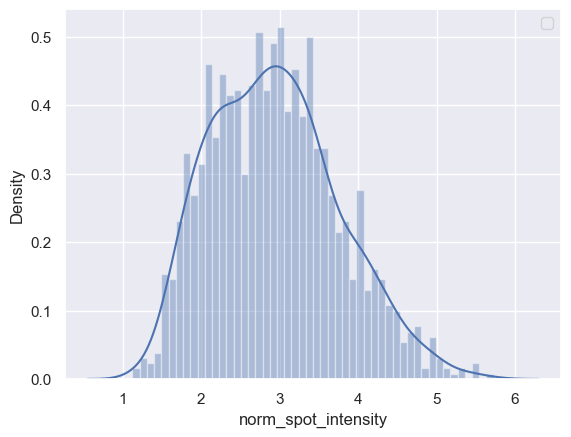

In [60]:
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

sns.distplot(
    np.log(summary_data_fid8_int['norm_spot_intensity']), bins=50,
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示

ここで、
np.log(3) = 1.0986
を閾値にして、それ以下のものを切り捨てる。
さらに、ここではすでにfiducial markerがなくなっているので、各細胞の中で輝度が上位4つに入るものだけを選抜する。

In [61]:
_df = summary_data_fid8_int.loc[summary_data_fid8_int['norm_spot_intensity']>np.log(3),:]
summary_data_fid9_int = pd.DataFrame()

for fov in range(1,4):
    print('fov : ' + str(fov))
    _df1 = _df.loc[_df['fov']==fov,]
    cell_list = list(set(_df1.cellID.values))
    for cell in cell_list:
        _df2 = _df1.loc[_df1['cellID']==cell,]
        geneID_list = list(set(_df2.geneID.values))
        for geneID in geneID_list:
            _df3 = _df2.loc[_df2['geneID']==geneID,]
            if len(_df3) > 4:
                _df4 = _df3.sort_values(by='norm_spot_intensity', ascending=False).head(4)
            else : 
                _df4 = _df3
            summary_data_fid9_int = pd.concat([summary_data_fid9_int, _df4])

fov : 1
fov : 2
fov : 3


In [62]:
summary_data_fid9_int

,fov,cellID,channel,geneID,x,y,z,Stack_ID,spot_intensity,norm_spot_intensity
129,1,6,2,Golt1b,82.979541,223.851781,56.300330,ND68_C2_TyD,1997,18.839623
41,1,6,1,Nanog_assoc#5,81.152279,222.801247,52.128965,ND43_C1_TyD,3221,37.894118
26,1,6,3,Bhlhe40,80.822886,211.898016,44.932099,ND38_C3_TyD,997,12.620253
27,1,6,3,Bhlhe40,67.113656,206.237793,45.357847,ND38_C3_TyD,640,8.101266
30,1,6,3,Bhlhe40,128.169641,186.989808,59.386317,ND38_C3_TyD,2641,33.430380
...,...,...,...,...,...,...,...,...,...,...
1427,3,4,2,Non_Nanog_assoc#18,192.178218,199.273899,45.898512,ND66_C2_TyD,2930,29.009901
1429,3,4,2,Non_Nanog_assoc#18,165.014418,134.379808,51.234915,ND66_C2_TyD,2455,24.306931
998,3,4,3,Non_Nanog_assoc#2,180.187498,147.628471,44.730245,ND35_C3_TyD,3036,42.166667
1000,3,4,3,Non_Nanog_assoc#2,181.991511,209.819063,49.587579,ND35_C3_TyD,1173,16.291667


In [64]:
os.makedirs(os.path.join(dir, "2_analyzed_data"), exist_ok=True)
summary_data_fid9_int.to_csv(os.path.join(dir, "2_analyzed_data", "corrected_spots_for_k_means.csv"),
                        index = False)